In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from kaggle_environments import evaluate, make, utils
import numpy as np
import random
from random import choice
from torch.distributions import uniform

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from torchsummary import summary

env = make("connectx", debug=True)
env.render()

In [2]:
# default agent with random strategy
def default_agent(observation, configuration):
    from random import choice
    return choice([c for c in range(configuration.columns) if observation.board[c] == 0])

In [3]:
# extraction of observations as matrix
def obs_to_matrix(observation, H, W):
    obs_list = []
    obs_list = observation.board   
    if observation.mark == 2: # my agent has mark 1 everytime
        for num in obs_list:
            if num == 2:
                num = 1
            if num == 1:
                num =2                
    obs_data = np.asarray(obs_list, dtype=np.float32).reshape((H,W))
    return obs_data

# we will allow our agent to obtain hxw matrix 
# from HxW observation matrix using random choice
def agent_attention(observation, H, W, h, w):
    dh_range = [i for i in range(H-h+1)]
    dw_range = [i for i in range(W-w+1)]
    dh = random.choice(dh_range)
    dw = random.choice(dw_range)
    obs_list = []
    obs_list = observation.board   
    if observation.mark == 2: # my agent has mark 1 everytime
        for num in obs_list:
            if num == 2: num = 1
            if num == 1: num =2                
    obs_matrix = np.asarray(obs_list).reshape((H,W))
    res_obs_matrix = np.zeros((h,w))
    
    for i in range(dh,dh+h,1):
        mas = obs_matrix[i][W-dw-w:W-dw]
        res_obs_matrix[i-dh,:] = mas[:]
    
    res_obs = res_obs_matrix.reshape(h*w,) 
    return res_obs, res_obs_matrix, dw

In [12]:
# we can help agent to find 5 pattern from all available
def detect_pattern(obs_matrix, r):
    H = obs_matrix.shape[0]
    W = obs_matrix.shape[1]
    m = obs_matrix
       
    agent_pattern = list(np.full((r,), 1))
    agent_pattern[-1] = 0    
    enemy_pattern = list(np.full((r,), 2))
    enemy_pattern[-1] = 0
       
    exist_agent_pattern = False
    exist_enemy_pattern = False
    agent_target = None
    enemy_target = None
    
    for i in range(H-1,-1,-1):
        for j in range(W-1,-1,-1):
            #vertical pattern
            if i>=r-1:
                p_list = []
                for k in range(r): p_list.append(m[i-k,j])
                if p_list == agent_pattern:
                    exist_agent_pattern = True
                    agent_target = j
                if p_list == enemy_pattern:
                    exist_enemy_pattern = True
                    enemy_target = j
                   
            #gorizontal pattern 
            if exist_agent_pattern == False or exist_enemy_pattern == False:                       
                if j>=r-1:
                    p_list = []
                    for k in range(r): p_list.append(m[i,j-k])
                    if exist_agent_pattern == False:
                        if p_list == agent_pattern and (i==H-1 or m[i+1,j-(r-1)]!=0):
                            exist_agent_pattern = True
                            agent_target = j-(r-1)
                    if exist_enemy_pattern == False:
                        if p_list == enemy_pattern and (i==H-1 or m[i+1,j-(r-1)]!=0):
                            exist_enemy_pattern = True
                            enemy_target = j-(r-1)
                            
            if exist_agent_pattern == False or exist_enemy_pattern == False: 
                if j<=r-1:
                    p_list = []
                    for k in range(r): p_list.append(m[i,j+k])
                    if exist_agent_pattern == False:
                        if p_list == agent_pattern and (i==H-1 or m[i+1,j+(r-1)]!=0):
                            exist_agent_pattern = True
                            agent_target = j+(r-1)
                    if exist_enemy_pattern == False:
                        if p_list == enemy_pattern and (i==H-1 or m[i+1,j+(r-1)]!=0):
                            exist_enemy_pattern = True
                            enemy_target = j+(r-1)
                                                            
            #diagonal pattern
            if exist_agent_pattern == False or exist_enemy_pattern == False:                 
                if i>=r-1 and j>=r-1:
                    p_list = []
                    for k in range(r): p_list.append(m[i-k,j-k])
                    if exist_agent_pattern == False:
                        if p_list == agent_pattern:
                            if m[i-(r-2),j-(r-1)]!=0:
                                exist_agent_pattern = True
                                agent_target = j-(r-1)
                    if exist_enemy_pattern == False:
                        if p_list == enemy_pattern:
                            if m[i-(r-2),j-(r-1)]!=0:
                                exist_enemy_pattern = True
                                enemy_target = j-(r-1) 
                            
            if exist_agent_pattern == False or exist_enemy_pattern == False:  
                if i>=r-1 and j<=r-1:
                    p_list = []
                    for k in range(r): p_list.append(m[i-k,j+k])
                    if exist_agent_pattern == False:
                        if p_list == agent_pattern and (m[i-(r-2),j+(r-1)]!=0):
                            exist_agent_pattern = True
                            agent_target = j+(r-1)
                    if exist_enemy_pattern == False:
                        if p_list == enemy_pattern and (m[i-(r-2),j+(r-1)]!=0):
                            exist_enemy_pattern = True
                            enemy_target = j+(r-1)
                                               
    return exist_agent_pattern, agent_target, exist_enemy_pattern, enemy_target  

In [13]:
# creating of our agent
def super_agent(observation, configuration):
    
    H = configuration.rows
    W = configuration.columns
    r = configuration.inarow
    h = 6
    w = 7
    delta = W-w
    
    # find simple patterns
    all_actions = [i for i in range(W)]
    obs_matrix = obs_to_matrix(observation, H, W)
    top_positions = obs_matrix[0]
    for i in range(W):
            if top_positions[i]!=0:
                all_actions.remove(i)
    
    agent_pattern, agent_target, enemy_pattern, enemy_target = detect_pattern(obs_matrix, r)
       
    if agent_pattern == True and agent_target!=None:
        action = agent_target
    elif enemy_pattern == True and enemy_target!= None and agent_pattern == False and agent_target==None:
        action = enemy_target
    
    # find action using DNN
    if agent_pattern == False and enemy_pattern == False:
        if H>=h and W>=w:
            res_obs, res_obs_matrix, dw = agent_attention(observation, H, W, h, w)
            res_obs_data = torch.tensor(res_obs, dtype=torch.float)
            logits = model_dnn(res_obs_data)
            predictions = torch.nn.functional.softmax(logits, dim=0)
            action = int(torch.argmax(predictions).detach().numpy()) + (delta-dw)
            max_proba = torch.max(predictions)
            distribution = uniform.Uniform(torch.Tensor([0.0]),torch.Tensor([1.0]))
            select_action = (max_proba > distribution.sample(torch.Size([1,1]))[0][0][0]/1)
            if select_action != True or top_positions[action]!=0:
                action = random.choice(all_actions)
                  
        else:
            action = random.choice([c for c in range(configuration.columns) if observation.board[c] == 0])        
    return action  

In [25]:
# creating of network

h = 6
w = 7

input_size = h*w
hidden_sizes = [256, 64]
output_size = w
# Build a feed-forward network

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__() 
        self.fc1 = nn.Linear(input_size,hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0],hidden_sizes[1])
        self.elu = nn.ELU() 
        self.dropout = nn.Dropout(p=0.5) #dropout modul
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        
    def forward(self, x): #feed forward
        x = self.elu(self.fc1(x))
        x = self.elu(self.fc2(self.dropout(x)))
        x = (self.fc3(self.dropout(x)))
        return F.log_softmax(x, dim = 0) #softmax activation to x
    
model_dnn = DNN()

summary(model_dnn, input_size= (1, h*w))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]          11,008
               ELU-2               [-1, 1, 256]               0
           Dropout-3               [-1, 1, 256]               0
            Linear-4                [-1, 1, 64]          16,448
               ELU-5                [-1, 1, 64]               0
           Dropout-6                [-1, 1, 64]               0
            Linear-7                 [-1, 1, 7]             455
Total params: 27,911
Trainable params: 27,911
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.11
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


In [16]:
# test without training in order to be aware that everything's OK

env.configuration.rows = 6 # H
env.configuration.columns = 7 # W

env.reset()
env.run([super_agent, default_agent])
env.render(mode="ipython")

In [17]:
# custom training function
def train_dnn_agent(model, trainer_agent=default_agent, n_env=200, n_it=150, leaning_rate=0.001, H=6, W=7, h=6, w=7):
    
    delta = W-w
    n_environments = n_env
    n_iterations = n_it

    envs = [make("connectx", debug=True) for _ in range(n_environments)]
    for env in envs:
        env.configuration.rows=H
        env.configuration.columns=W
        
    env = make("connectx", debug=True)
    env.configuration.rows=H
    env.configuration.columns=W
    trainer = env.train([None, trainer_agent])
    observations = [trainer.reset() for env in envs]

    optimizer = torch.optim.Adam(model.parameters(), lr=leaning_rate)
    loss_fn = nn.CrossEntropyLoss()
    
    total_reward = []
    total_loss = []
    
    for iteration in range(n_iterations): 
        actions = []
        output = torch.zeros(n_environments, w,  dtype=torch.float)
        targets = torch.zeros(n_environments, dtype=torch.int64)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        for i in range(n_environments):
            observation = observations[i]
            all_actions_res = [i for i in range(w)]
            
            res_obs, res_obs_matrix, dw = agent_attention(observation, H, W, h, w)
            res_obs_data = torch.tensor(res_obs, dtype=torch.float)
            logits = model(res_obs_data)
            predictions = torch.nn.functional.softmax(logits, dim=0)
            action = int(torch.argmax(predictions).detach().numpy())
            max_proba = torch.max(predictions)
            distribution = uniform.Uniform(torch.Tensor([0.0]),torch.Tensor([1.0]))
            select_action = (max_proba > distribution.sample(torch.Size([1,1]))[0][0][0]/1)
    
            if select_action != True:
                action = random.choice(all_actions_res)                
                
            actions.append(action + (delta-dw))       
            output[i,:] = predictions[:]
            targets[i] = action
            
        loss = loss_fn(output, targets)
        total_loss.append(float(loss.detach().numpy()))
        print("\rIteration: {}, Loss: {:.3f}".format(iteration, float(loss.detach().numpy())), end="")
        
        loss.backward()
        optimizer.step()
        
        it_reward = []
    
        for env_index, env in enumerate(envs):
            all_actions = [i for i in range(W)]
            action = actions[env_index]
            obs_matrix = obs_to_matrix(observations[env_index], H, W)
            top_positions = obs_matrix[0]
            
            for i in range(W):
                if top_positions[i]!=0:
                    all_actions.remove(i)
            if top_positions[action]!=0:
                action = random.choice(all_actions)
                    
            obs, reward, done, info = trainer.step(action)
            observations[env_index] = obs if not done else trainer.reset()          
            it_reward.append(reward)
            if None in it_reward: it_reward.remove(None)
                
        total_reward.append(sum(it_reward)/n_environments)
        
    return total_loss, total_reward 

In [26]:
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic=True           

In [27]:
# train in 6X7 env
agent_loss, agent_reward = train_dnn_agent(model_dnn, default_agent, n_env=200, n_it=150, H=6, W=7, h=6, w=7)

Iteration: 0, Loss: 1.944Invalid Action: Invalid column: 2
Invalid Action: Invalid column: 2
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Iteration: 1, Loss: 1.934Invalid Action: Invalid column: 2
Invalid Action: Invalid column: 3
Invalid Action: Invalid column: 6
Invalid Action: Invalid column: 3
Iteration: 2, Loss: 1.933Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 6
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 5
Iteration: 3, Loss: 1.923Invalid Action: Invalid column: 3
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 6
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 6
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 1
Iteration: 4, Loss: 1.929Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 6
Iteration: 5, Loss: 1.913

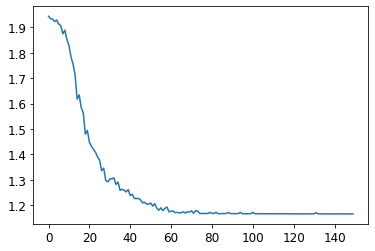

In [28]:
# Losses
plt.plot(agent_loss)

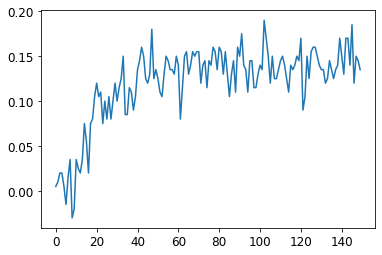

In [29]:
# Rewards
plt.plot(agent_reward)

In [30]:
torch.save(model_dnn.state_dict(), 'model_superagent_step_1_2')

In [31]:
# Evaluate our Agent

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

num_episodes = 100

print("Super Agent vs Random Agent:", mean_reward(evaluate("connectx", [super_agent, 'random'], num_episodes=num_episodes)))
print("Super Agent vs negamax Agent:", mean_reward(evaluate("connectx", [super_agent, 'negamax'], num_episodes=num_episodes)))
print("Super Agent vs Defalt Agent:", mean_reward(evaluate("connectx", [super_agent, default_agent], num_episodes=num_episodes)))
print("Super Agent vs Super Agent:", mean_reward(evaluate("connectx", [super_agent, super_agent], num_episodes=num_episodes)))

Super Agent vs Random Agent: 0.76
Super Agent vs negamax Agent: -0.67
Super Agent vs Defalt Agent: 0.81
Super Agent vs Super Agent: -0.02


In [32]:
env.configuration.rows = 6 # H
env.configuration.columns = 7 # W

env.reset()
env.run([super_agent, 'random'])
env.render(mode="ipython")

In [33]:
# We will create a copy of our agent to train the agent with itself

model_007 = DNN()

model_007.load_state_dict(torch.load('model_superagent_step_1_2')) 

def agent_007(observation, configuration):
    
    H = configuration.rows
    W = configuration.columns
    r = configuration.inarow
    h = 6
    w = 7
    delta = W-w
    
    # find simple patterns
    all_actions = [i for i in range(W)]
    obs_matrix = obs_to_matrix(observation, H, W)
    top_positions = obs_matrix[0]
    for i in range(W):
            if top_positions[i]!=0:
                all_actions.remove(i)
    
    agent_pattern, agent_target, enemy_pattern, enemy_target = detect_pattern(obs_matrix, r)
       
    if agent_pattern == True and agent_target!=None:
        action = agent_target
    elif enemy_pattern == True and enemy_target!= None and agent_pattern == False and agent_target==None:
        action = enemy_target
    
    # find action using DNN
    if agent_pattern == False and enemy_pattern == False:
        if H>=h and W>=w:
            res_obs, res_obs_matrix, dw = agent_attention(observation, H, W, h, w)
            res_obs_data = torch.tensor(res_obs, dtype=torch.float)
            logits = model_007(res_obs_data)
            predictions = torch.nn.functional.softmax(logits, dim=0)
            action = int(torch.argmax(predictions).detach().numpy()) + (delta-dw)
            max_proba = torch.max(predictions)
            distribution = uniform.Uniform(torch.Tensor([0.0]),torch.Tensor([1.0]))
            select_action = (max_proba > distribution.sample(torch.Size([1,1]))[0][0][0]/1)
            if select_action != True or top_positions[action]!=0:
                action = random.choice(all_actions)
                  
        else:
            action = random.choice([c for c in range(configuration.columns) if observation.board[c] == 0])        
    return action  

In [34]:
# training of our agent using set of different trainers
def train_dnn_agent_2(model, n_it=150, leaning_rate=0.001, H=6, W=7, h=6, w=7):
    
    delta = W-w
    n_environments = 24
    n_iterations = n_it

    envs = [make("connectx", debug=True) for _ in range(n_environments)]
    for env in envs:
        env.configuration.rows=H
        env.configuration.columns=W
        
    env = make("connectx", debug=True)
    env.configuration.rows=H
    env.configuration.columns=W
    
    trainer = [env.train([None, default_agent]), env.train([None, default_agent]), env.train([None, default_agent]), 
               env.train([None, 'negamax']), env.train([None, 'negamax']), env.train([None, 'negamax']),
               env.train([None, 'random']), env.train([None, 'random']), env.train([None, 'random']),
               env.train([None, agent_007]), env.train([None, agent_007]), env.train([None, agent_007]),
               env.train([None, default_agent]), env.train([None, default_agent]), env.train([None, default_agent]),
               env.train([None, 'negamax']), env.train([None, 'negamax']), env.train([None, 'negamax']),
               env.train([None, 'random']), env.train([None, 'random']), env.train([None, 'random']),
               env.train([None, agent_007]), env.train([None, agent_007]), env.train([None, agent_007])]
    
    observations = []
    for env_index, env in enumerate(envs):
        observations.append(trainers[env_index].reset())

    optimizer = torch.optim.Adam(model.parameters(), lr=leaning_rate)
    loss_fn = nn.CrossEntropyLoss()
    
    total_reward = []
    total_loss = []
    
    for iteration in range(n_iterations): 
        actions = []
        output = torch.zeros(n_environments, w,  dtype=torch.float)
        targets = torch.zeros(n_environments, dtype=torch.int64)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        for i in range(n_environments):
            observation = observations[i]
            all_actions_res = [i for i in range(w)]
            
            res_obs, res_obs_matrix, dw = agent_attention(observation, H, W, h, w)
            res_obs_data = torch.tensor(res_obs, dtype=torch.float)
            logits = model(res_obs_data)
            predictions = torch.nn.functional.softmax(logits, dim=0)
            action = int(torch.argmax(predictions).detach().numpy())
            max_proba = torch.max(predictions)
            distribution = uniform.Uniform(torch.Tensor([0.0]),torch.Tensor([1.0]))
            select_action = (max_proba > distribution.sample(torch.Size([1,1]))[0][0][0]/1)
    
            if select_action != True:
                action = random.choice(all_actions_res)                
                
            actions.append(action + (delta-dw))       
            output[i,:] = predictions[:]
            targets[i] = action
            
        loss = loss_fn(output, targets)
        total_loss.append(float(loss.detach().numpy()))
        print("\rIteration: {}, Loss: {:.3f}".format(iteration, float(loss.detach().numpy())), end="")
        
        loss.backward()
        optimizer.step()
        
        it_reward = []
    
        for env_index, env in enumerate(envs):
            all_actions = [i for i in range(W)]
            action = actions[env_index]
            obs_matrix = obs_to_matrix(observations[env_index], H, W)
            top_positions = obs_matrix[0]
            
            for i in range(W):
                if top_positions[i]!=0:
                    all_actions.remove(i)
            if top_positions[action]!=0:
                action = random.choice(all_actions)
                    
            obs, reward, done, info = trainers[env_index].step(action)
            observations[env_index] = obs if not done else trainers[env_index].reset()
            it_reward.append(reward)
            if None in it_reward: it_reward.remove(None)
                
        total_reward.append(sum(it_reward)/n_environments)
        
    return total_loss, total_reward 

In [45]:
model_dnn.load_state_dict(torch.load('model_superagent_step_1_2')) 

<All keys matched successfully>

In [46]:
# train in 6X7 env
agent_loss, agent_reward = train_dnn_agent_2(model_dnn, n_it=200, leaning_rate=0.001, H=6, W=7, h=6, w=7)

Iteration: 0, Loss: 1.168Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Iteration: 1, Loss: 1.166Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Iteration: 2, Loss: 1.166Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Iteration: 3, Loss: 1.166Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Iteration: 4, Loss: 1.165Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Iteration: 5, Loss: 1.166Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Iteration: 6, Loss: 1.165Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Iteration

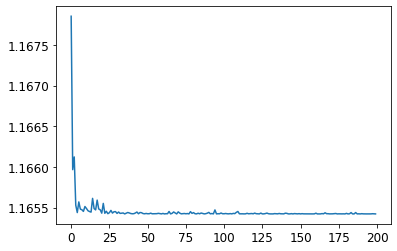

In [47]:
# Losses
plt.plot(agent_loss)

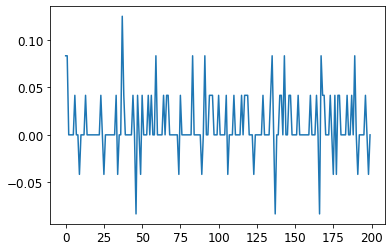

In [48]:
# Rewards
plt.plot(agent_reward)

In [49]:
# Evaluation
print("Super Agent vs Random Agent:", mean_reward(evaluate("connectx", [super_agent, 'random'], num_episodes=num_episodes)))
print("Super Agent vs negamax Agent:", mean_reward(evaluate("connectx", [super_agent, 'negamax'], num_episodes=num_episodes)))
print("Super Agent vs Defalt Agent:", mean_reward(evaluate("connectx", [super_agent, default_agent], num_episodes=num_episodes)))
print("Super Agent vs Super Agent:", mean_reward(evaluate("connectx", [super_agent, super_agent], num_episodes=num_episodes)))

Super Agent vs Random Agent: 0.83
Super Agent vs negamax Agent: -0.66
Super Agent vs Defalt Agent: 0.77
Super Agent vs Super Agent: 0.19


In [50]:
torch.save(model_dnn.state_dict(), 'model_superagent_step_4_2')

In [69]:
model_dnn.load_state_dict(torch.load('model_superagent_step_4_2')) 

<All keys matched successfully>

In [51]:
# We can remove ramdom actions from agent function

def super_agent(observation, configuration):
    
    H = configuration.rows
    W = configuration.columns
    r = configuration.inarow
    h = 6
    w = 7
    delta = W-w
    
    # find simple patterns
    all_actions = [i for i in range(W)]
    obs_matrix = obs_to_matrix(observation, H, W)
    top_positions = obs_matrix[0]
    for i in range(W):
            if top_positions[i]!=0:
                all_actions.remove(i)
    
    agent_pattern, agent_target, enemy_pattern, enemy_target = detect_pattern(obs_matrix, r)
       
    if agent_pattern == True and agent_target!=None:
        action = agent_target
    elif enemy_pattern == True and enemy_target!= None and agent_pattern == False and agent_target==None:
        action = enemy_target
    
    # find action using DNN
    if agent_pattern == False and enemy_pattern == False:
        if H>=h and W>=w:
            res_obs, res_obs_matrix, dw = agent_attention(observation, H, W, h, w)
            res_obs_data = torch.tensor(res_obs, dtype=torch.float)
            logits = model_dnn(res_obs_data)
            predictions = torch.nn.functional.softmax(logits, dim=0)
            action = int(torch.argmax(predictions).detach().numpy()) + (delta-dw)
            
            #max_proba = torch.max(predictions)
            #distribution = uniform.Uniform(torch.Tensor([0.0]),torch.Tensor([1.0]))
            #select_action = (max_proba > distribution.sample(torch.Size([1,1]))[0][0][0]/1)
            #if select_action != True or top_positions[action]!=0:
                #action = random.choice(all_actions)
            
            if top_positions[action]!=0:
                action = random.choice(all_actions)
        # random regime        
        else:
            action = random.choice([c for c in range(configuration.columns) if observation.board[c] == 0])        
    return action  

In [54]:
# Evaluation

print("Super Agent vs Random Agent:", mean_reward(evaluate("connectx", [super_agent, 'random'], num_episodes=num_episodes)))
print("Super Agent vs negamax Agent:", mean_reward(evaluate("connectx", [super_agent, 'negamax'], num_episodes=num_episodes)))
print("Super Agent vs Defalt Agent:", mean_reward(evaluate("connectx", [super_agent, default_agent], num_episodes=num_episodes)))
print("Super Agent vs Super Agent:", mean_reward(evaluate("connectx", [super_agent, super_agent], num_episodes=num_episodes)))

Super Agent vs Random Agent: 0.8
Super Agent vs negamax Agent: -0.67
Super Agent vs Defalt Agent: 0.9
Super Agent vs Super Agent: 0.04


In [55]:
env.reset()
env.run([super_agent, default_agent])
env.render(mode="ipython")